In [1]:
import time
!pip install pandas_datareader

import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader as web

import pandas_datareader.data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

    100% |████████████████████████████████| 112kB 2.1MB/s ta 0:00:01
    100% |████████████████████████████████| 5.8MB 99kB/s  eta 0:00:01
  Running setup.py bdist_wheel for requests-ftp ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/2a/98/32/37195e45a3392a73d9f65c488cbea30fe5bad76aaef4d6b020
  Running setup.py bdist_wheel for wrapt ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/48/5d/04/22361a593e70d23b1f7746d932802efe1f0e523376a74f321e
Successfully built requests-ftp wrapt
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


/srv/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/srv/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import os
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

In [4]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2016-01-01', '%Y-%m-%d') 
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [10]:
crypto = ['BTC', 'ETH', 'LTC','XRP']

crypto_data = {}
for coin in crypto:
    coinpair = 'USDT_{}'.format(coin)
    crypto_price_df = get_crypto_data(coinpair)
    crypto_data[coin] = crypto_price_df
    

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1451606400.0&end=1535637371.136992&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1451606400.0&end=1535637371.136992&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_LTC&start=1451606400.0&end=1535637371.136992&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_XRP&start=1451606400.0&end=1535637371.136992&period=86400 from cache


In [7]:
df = pd.concat([crypto_data['BTC']['close'],crypto_data['ETH']['close'],crypto_data['LTC']['close'],crypto_data['XRP']['close']], axis=1)

In [8]:
df.columns = ['BTC-USD', 'ETH-USD', 'LTC-USD','XRP-USD']
df.tail()

,BTC-USD,ETH-USD,LTC-USD,XRP-USD
date,,,,
2018-08-26,6713.151600,274.390000,56.763112,0.322134
2018-08-27,6905.000000,287.795429,60.578373,0.338300
2018-08-28,7076.191190,295.777737,63.340646,0.351256
2018-08-29,7032.115216,288.239975,61.703456,0.345000
2018-08-30,6855.802863,278.190193,59.218186,0.328595


In [18]:
# reorganise data pulled by setting date as index with
# columns of tickers and their corresponding adjusted prices
#clean = df.set_index('date')
#table = df.pivot(columns='close')

selected = ['BTC', 'ETH', 'LTC','XRP']

# calculate daily and annual returns of the stocks
returns_daily = df.pct_change()
returns_annual = returns_daily.mean() * 250

# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

#set random seed for reproduction's sake
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

# reorder dataframe columnsj
df = df[column_order]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

ValueError: shapes (4,) and (7,) not aligned: 4 (dim 0) != 7 (dim 0)

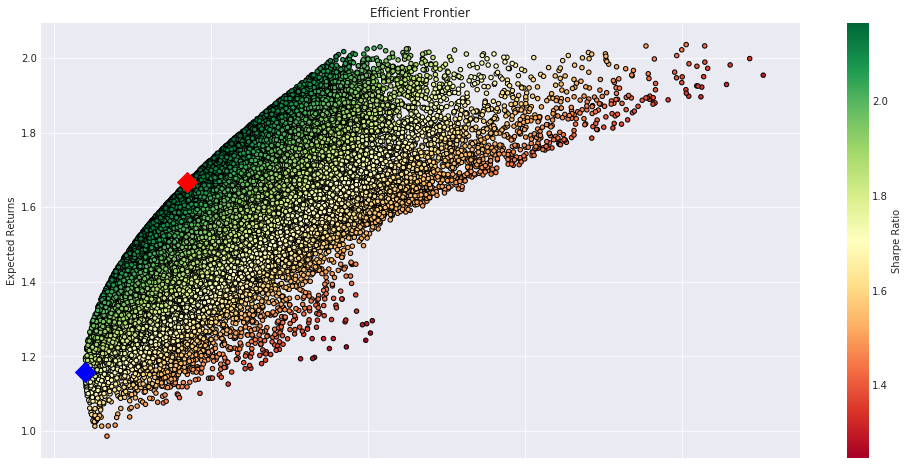

In [21]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(17, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()